# softmax实现练习
 在本章练习中我们将逐步完成：
* 1.熟悉使用CIFAR-10 数据集
* 2.编码softmax_loss_naive函数 使用显式循环计算损失函数以及梯度
* 3.编码softmax_loss_vectorized函数  使用向量化表达计算损失函数以及梯度
* 4.编码最小批量梯度下降算法 训练softmax分类器
* 5.使用验证数据选择超参数

In [1]:
#-*- coding: utf-8 -*-
import random
import numpy as np
from utils.data_utils import load_CIFAR10
from classifiers.chapter2 import *
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) 
%load_ext autoreload
%autoreload 2

In [2]:
# 导入 CIFAR-10 数据.
cifar10_dir = 'datasets\\cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# 查看数据
print('训练数据（数据个数，数据维度）: ', X_train.shape)
print('训练数据标记（数据标记个数，）: ', y_train.shape)
print('测试数据（数据个数，数据维度）: ', X_test.shape)
print('测试数据标记（数据标记个数，）: ', y_test.shape)

训练数据（数据个数，数据维度）:  (50000, 32, 32, 3)
训练数据标记（数据标记个数，）:  (50000,)
测试数据（数据个数，数据维度）:  (10000, 32, 32, 3)
测试数据标记（数据标记个数，）:  (10000,)


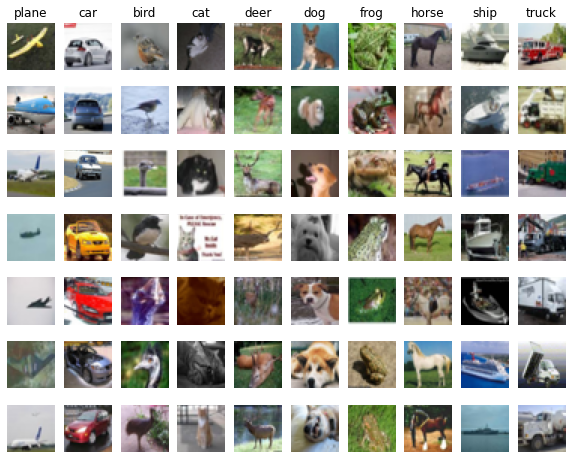

In [3]:
# 数据可视化.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
# 类别总数
num_classes = len(classes)
# 每个类别采样个数
samples_per_class = 7
for y, cls in enumerate(classes): # 对列表的元素位置和元素进行循环，y表示元素位置（0,num_class），cls元素本身'plane'等
    # numpy.flatnonzero():
    # 该函数输入一个矩阵，返回扁平化后矩阵中非零元素的位置（index）
    idxs = np.flatnonzero(y_train == y)  # 找出标签中y类的位置
    idxs = np.random.choice(idxs, samples_per_class, replace=False) #从中选出我们所需的7个样本
    for i, idx in enumerate(idxs): # 对所选的样本的位置和样本所对应的图片在训练集中的位置进行循环
        plt_idx = i * num_classes + y + 1  # 在子图中所占位置的计算
        plt.subplot(samples_per_class, num_classes, plt_idx)  # 说明要画的子图的编号
        plt.imshow(X_train[idx].astype('uint8'))  # 画图
        plt.axis('off')
        if i == 0:
            plt.title(cls)  # 写上标题，也就是类别名
plt.show()  # 显示

## 1.数据预处理
在通常情况下，我们需要对输入数据进行归一化处理，也就是使得数据呈均值为零，方差为1的标准正态分布。由于图像的特征范围在[0,255]，其方差已经被约束了，我们只需要将数据进行零均值中心化处理即可，不需要将数据压缩在[-1,1]范围(当然，你也可以进行此项处理)。

In [4]:
def get_CIFAR10_data(num_training=49000, num_validation=100, num_test=10000, num_sample=250):
    '''
    熟练使用CIFAR-10数据集
    CIFAR-10数据集包括了60000张，大小为32*32的十分类图片。
    num_training: 训练数据样本数
    num_validation: 验证数据样本数
    num_test: 测试数据样本数
    num_sample: 示例数据样本数
    '''
    # 导入 CIFAR-10 data
    cifar10_dir = 'datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # 采样数据
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask] 
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_sample, replace=False)
    X_sample = X_train[mask]
    y_sample = y_train[mask]
    
    # 数据形状转换
    # 将(宽，高，色道)压缩在一维上
    # 将数据重塑成（数据个数，维度）形状
    X_train = np.reshape(X_train,(X_train.shape[0], -1))
    X_val = np.reshape(X_val,(X_val.shape[0], -1))
    X_test = np.reshape(X_test,(X_test.shape[0], -1))
    X_sample = np.reshape(X_sample,(X_sample.shape[0], -1))
    
    # 数据归一化
    # 数据预处理，减去其均值
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_sample -= mean_image
    
    # 在每列数据中加入偏置项
    # np.hstack将参数元组的元素数组按水平方向进行叠加
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_sample = np.hstack([X_sample, np.ones((X_sample.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_sample, y_sample

X_train, y_train, X_val, y_val, X_test, y_test, X_sample, y_sample = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('sample data shape: ', X_sample.shape)
print('sample labels shape: ', y_sample.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (100, 3073)
Validation labels shape:  (100,)
Test data shape:  (10000, 3073)
Test labels shape:  (10000,)
sample data shape:  (250, 3073)
sample labels shape:  (250,)


## 2.使用显式循环计算损失函数以及梯度

请尽可能少地使用循环，使用的循环越少，就可以节约更多的计算时间。需要逐渐地适应向量化计算表达，因为采用向量化表达，既书写简介，使得代码的可读性大大提高，不容易产生错误，又极大地提高了运算效率。

In [5]:
# 首先我们将用循环的方式实现softmax的损失函数（代价函数）
# 打开 classifiers/chapter2/softmax_loss.py 文件并实现softmax_loss_naive函数
# 完成之后运行该单元代码
from classifiers.chapter2.softmax_loss import softmax_loss_naive
import time

# 初始化权重
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_sample, y_sample, 0.0)

# 你的初始化损失值应该接近于 -log(0.1).
print('你实现的softmax损失值loss: %f' % loss)
print('正确的损失值: %f' % ( -np.log(0.1) ))

你实现的softmax损失值loss: 2.322683
正确的损失值: 2.302585


In [6]:
# 使用数值梯度检验你已实现的softmax_loss_naive
# 你实现的梯度应该要接近于数值梯度
from utils.gradient_check import grad_check_sparse
loss, grad = softmax_loss_naive(W, X_sample, y_sample, 0.0)

print('检验无权重衰减的softmax_loss_naive梯度：')
f = lambda w: softmax_loss_naive(w, X_sample, y_sample, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

print('检验加入权重衰减项后的softmax_loss_naive梯度：')
loss, grad = softmax_loss_naive(W, X_sample, y_sample, 1e2)
f = lambda w: softmax_loss_naive(w, X_sample, y_sample, 1e2)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

检验无权重衰减的softmax_loss_naive梯度：
numerical: -1.643731 analytic: -1.643731, relative error: 1.767333e-08
numerical: -0.903899 analytic: -0.903899, relative error: 4.933728e-08
numerical: -1.871885 analytic: -1.871886, relative error: 1.466657e-08
numerical: 1.315985 analytic: 1.315985, relative error: 2.012378e-08
numerical: 1.398138 analytic: 1.398138, relative error: 2.379984e-08
numerical: 0.787859 analytic: 0.787859, relative error: 3.121790e-08
numerical: -2.592382 analytic: -2.592382, relative error: 2.092500e-08
numerical: -2.854713 analytic: -2.854713, relative error: 7.280248e-09
numerical: 1.232664 analytic: 1.232664, relative error: 2.542693e-08
numerical: 1.706167 analytic: 1.706167, relative error: 3.109060e-08
检验加入权重衰减项后的softmax_loss_naive梯度：
numerical: -0.176439 analytic: -0.176439, relative error: 3.089932e-07
numerical: -3.940286 analytic: -3.940286, relative error: 7.815151e-09
numerical: -1.458173 analytic: -1.458173, relative error: 3.271034e-09
numerical: -0.478771 ana

## 3. 使用向量化表达计算损失函数以及梯度

In [7]:
# 现在我们将实现向量化的softmax损失及其梯度计算
# 打开softmax_loss_vectorized函数并完成相应任务，运行该段代码
# 向量化版本应该和显式循环版本相同，但前者的计算效率应该快速得很多
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_sample, y_sample, 0.00001)
toc = time.time()
print('显式循环版loss: %e   花费时间 %fs' % (loss_naive, toc - tic))

from classifiers.chapter2.softmax_loss import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_sample, y_sample, 0.00001)
toc = time.time()
print('向量化版本 loss: %e    花费时间 %fs' % (loss_vectorized, toc - tic))

# 比较结果
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('损失误差: %f' % np.abs(loss_naive - loss_vectorized))
print('梯度误差: %f' % grad_difference)

显式循环版loss: 2.322683e+00   花费时间 0.101504s
向量化版本 loss: 2.322683e+00    花费时间 0.001956s
损失误差: 0.000000
梯度误差: 0.000000


## 4.最小批量梯度下降算法 训练softmax分类器

In [10]:
# 打开softmax.trian()完成随机梯度下降任务，然后执行该段代码
from classifiers.chapter2.softmax import *
softmax = Softmax()
tic = time.time()
loss_hist = softmax.train(X_sample, y_sample, learning_rate=1e-7, reg=5e4,
                      num_iters=3500, verbose=True)
toc = time.time()
print('花费时间 %fs' % (toc - tic))

迭代次数 0 / 3500: loss 777.592212
迭代次数 500 / 3500: loss 7.042712
迭代次数 1000 / 3500: loss 1.952050
迭代次数 1500 / 3500: loss 1.920996
迭代次数 2000 / 3500: loss 1.897792
迭代次数 2500 / 3500: loss 1.923868
迭代次数 3000 / 3500: loss 1.904769
花费时间 11.818226s


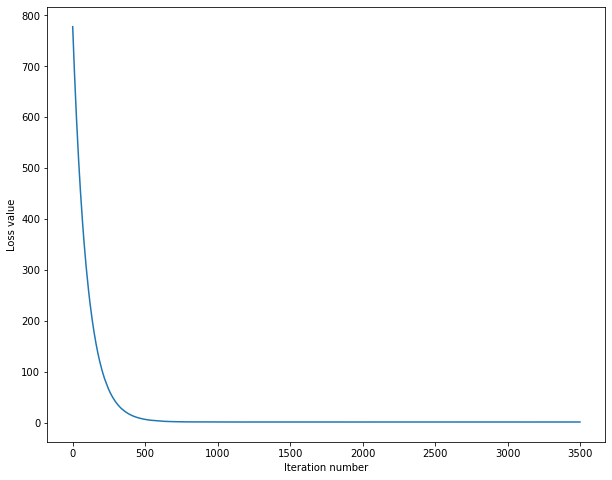

In [11]:
# 查看损失值的变化情况
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [12]:
# 测试训练集，验证集的精度
y_train_pred = softmax.predict(X_sample)
print(y_train_pred.shape)
print('训练数据量：%f    训练正确率: %f' % (X_sample.shape[0],np.mean(y_sample == y_train_pred), ))
y_val_pred = softmax.predict(X_val)
print('验证数据量：%f    验证正确率: %f' % (X_val.shape[0],np.mean(y_val == y_val_pred), ))

(250,)
训练数据量：250.000000    训练正确率: 0.576000
验证数据量：100.000000    验证正确率: 0.240000


## 5.使用验证数据选择超参数

In [13]:
# 使用验证集调整超参数(权重衰减因子，学习率)
from classifiers.chapter2.softmax import *
results = {}
best_val = -1
best_l = 0  # 最佳的学习率
best_r = 0  # 最佳的权重衰减因子
best_softmax = None
# 学习率
learning_rates=np.logspace(-9, 0, num=10)
# 权重衰减因子
regularization_strengths=np.logspace(0, 5, num=10)
batch_size = [50]
num_iters  = [300]

for b in batch_size:
    for n in num_iters:
        for l in learning_rates:
            for r in regularization_strengths:
                # 创建Softmax类来进行对比
                softmax = Softmax()
                loss_hist = softmax.train(X_sample, y_sample, 
                                         learning_rate=l,reg=r,
                                         num_iters=n,
                                         batch_size=b,
                                         verbose=False)
                y_train_pred = softmax.predict(X_sample)
                train_accuracy= np.mean(y_sample == y_train_pred)
                y_val_pred = softmax.predict(X_val)
                val_accuracy= np.mean(y_val == y_val_pred)
                results[(l,r)]=(train_accuracy,val_accuracy)
                # 找出准确率最高的参数配置
                if(best_val < val_accuracy):
                    best_val = val_accuracy
                    best_softmax = softmax
                    best_l =l
                    best_r =r
    
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e 训练精度: %f 验证精度: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('最佳学习率为：%e 最佳权重衰减系数为：%e 其所对应的验证精度为: %f' % (best_l,best_r,best_val))

D:\workspace\Python\jupyter\深度学习实战范例\DLAction\classifiers\chapter2\softmax_loss.py:111: RuntimeWarning: divide by zero encountered in log
  loss += -np.sum(y_trueClass*np.log(prob))/num_train+0.5*reg*np.sum(W*W)
D:\workspace\Python\jupyter\深度学习实战范例\DLAction\classifiers\chapter2\softmax_loss.py:111: RuntimeWarning: invalid value encountered in multiply
  loss += -np.sum(y_trueClass*np.log(prob))/num_train+0.5*reg*np.sum(W*W)
D:\workspace\Python\jupyter\深度学习实战范例\DLAction\classifiers\chapter2\softmax_loss.py:111: RuntimeWarning: overflow encountered in double_scalars
  loss += -np.sum(y_trueClass*np.log(prob))/num_train+0.5*reg*np.sum(W*W)
D:\ProgrammingTools\anaconda\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
D:\workspace\Python\jupyter\深度学习实战范例\DLAction\classifiers\chapter2\softmax_loss.py:111: RuntimeWarning: overflow encountered in multiply
  loss += -np.sum(y_trueClass*np.lo

lr 1.000000e-09 reg 1.000000e+00 训练精度: 0.152000 验证精度: 0.120000
lr 1.000000e-09 reg 3.593814e+00 训练精度: 0.064000 验证精度: 0.090000
lr 1.000000e-09 reg 1.291550e+01 训练精度: 0.116000 验证精度: 0.170000
lr 1.000000e-09 reg 4.641589e+01 训练精度: 0.048000 验证精度: 0.080000
lr 1.000000e-09 reg 1.668101e+02 训练精度: 0.104000 验证精度: 0.150000
lr 1.000000e-09 reg 5.994843e+02 训练精度: 0.148000 验证精度: 0.100000
lr 1.000000e-09 reg 2.154435e+03 训练精度: 0.096000 验证精度: 0.090000
lr 1.000000e-09 reg 7.742637e+03 训练精度: 0.112000 验证精度: 0.140000
lr 1.000000e-09 reg 2.782559e+04 训练精度: 0.064000 验证精度: 0.100000
lr 1.000000e-09 reg 1.000000e+05 训练精度: 0.108000 验证精度: 0.070000
lr 1.000000e-08 reg 1.000000e+00 训练精度: 0.108000 验证精度: 0.060000
lr 1.000000e-08 reg 3.593814e+00 训练精度: 0.104000 验证精度: 0.160000
lr 1.000000e-08 reg 1.291550e+01 训练精度: 0.092000 验证精度: 0.110000
lr 1.000000e-08 reg 4.641589e+01 训练精度: 0.080000 验证精度: 0.090000
lr 1.000000e-08 reg 1.668101e+02 训练精度: 0.136000 验证精度: 0.090000
lr 1.000000e-08 reg 5.994843e+02 训练精度: 0.132000 验证精度: 0

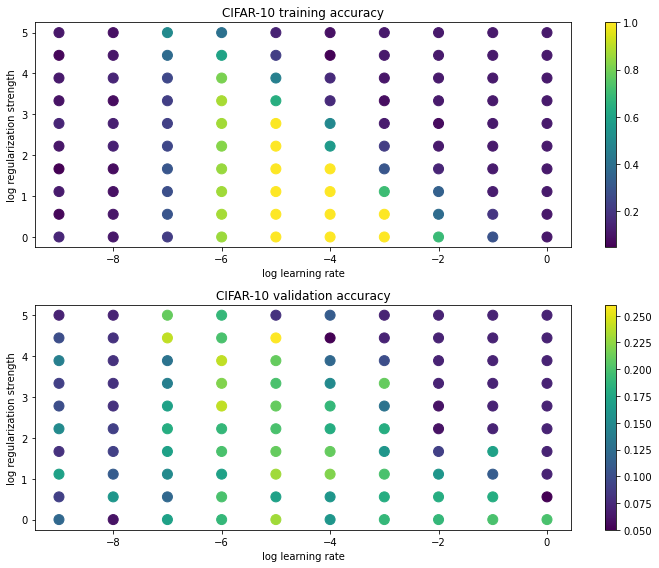

In [17]:
import math
# 生成对应的点图
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# 绘制训练数据精度
marker_size = 100
# 生产颜色
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
# 绘制相应点
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
# 添加颜色柱
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# 绘制验证数据精度
colors = [results[x][1] for x in results] 
plt.subplot(2, 1, 2)
# 绘制相应点
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
# 添加颜色柱
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
# 自动布局
plt.tight_layout()
plt.show()

从可视化结果可以清晰地看出，学习率大约在[1e-6, 1e-4]之间效果显著，惩罚因子在[1e0, 1e4]之间效果较好，并且惩罚因子越小可能效果越好。因此我们下一步就在这个范围内继续缩小。

In [23]:
#使用验证集调整超参数(权重衰减因子，学习率)
from classifiers.chapter2.softmax import *
results = {}
best_val = -1
best_l = 0
best_r = 0
best_softmax = None
learning_rates=np.logspace(-6, -4, num=10)
regularization_strengths=np.logspace(-1, 4, num=5)
batch_size = [50]
num_iters  = [300]

for b in batch_size:
    for n in num_iters:
        for l in learning_rates:
            for r in regularization_strengths:
                softmax = Softmax()
                loss_hist = softmax.train(X_sample, y_sample,
                                         learning_rate=l, reg=r,
                                         num_iters=n,batch_size=b, verbose=False)
                y_train_pred = softmax.predict(X_sample)
                train_accuracy= np.mean(y_sample == y_train_pred)
                y_val_pred = softmax.predict(X_val)
                val_accuracy= np.mean(y_val == y_val_pred)
                results[(l,r)]=(train_accuracy,val_accuracy)
                if (best_val < val_accuracy):
                    best_val = val_accuracy
                    best_softmax = softmax
                    best_l =l
                    best_r =r

    
print('最佳学习率为：%e 最佳权重衰减系数为：%e 其所对应的验证精度为: %f' % (best_l,best_r,best_val))

D:\workspace\Python\jupyter\深度学习实战范例\DLAction\classifiers\chapter2\softmax_loss.py:111: RuntimeWarning: divide by zero encountered in log
  loss += -np.sum(y_trueClass*np.log(prob))/num_train+0.5*reg*np.sum(W*W)
D:\workspace\Python\jupyter\深度学习实战范例\DLAction\classifiers\chapter2\softmax_loss.py:111: RuntimeWarning: invalid value encountered in multiply
  loss += -np.sum(y_trueClass*np.log(prob))/num_train+0.5*reg*np.sum(W*W)


最佳学习率为：1.291550e-05 最佳权重衰减系数为：1.000000e+04 其所对应的验证精度为: 0.240000


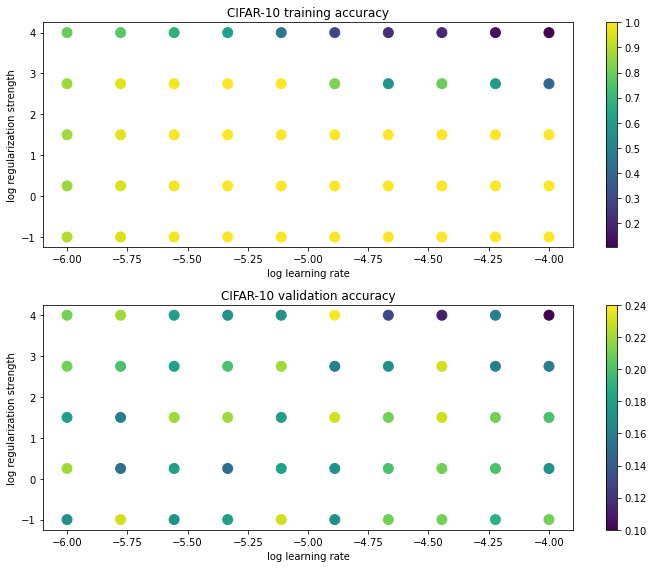

In [24]:
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]


# 绘制训练数据精度
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

#绘制验证数据精度
colors = [results[x][1] for x in results] 
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
# 自动布局
plt.tight_layout()
plt.show()

继续缩小参数范围。

In [25]:
#使用验证集调整超参数(权重衰减因子，学习率)
from classifiers.chapter2.softmax import *
results = {}
best_val = -1
best_l = 0
best_r = 0
best_softmax = None
learning_rates=np.logspace(-5, -4, num=10)
regularization_strengths=np.logspace(-2, 3, num=5)
batch_size = [50]
num_iters  = [300]

for b in batch_size:
    for n in num_iters:
        for l in learning_rates:
            for r in regularization_strengths:
                softmax = Softmax()
                loss_hist = softmax.train(X_sample, y_sample, learning_rate=l,
                                         reg=r,num_iters=n,batch_size=b, verbose=False)
                y_train_pred = softmax.predict(X_sample)
                train_accuracy= np.mean(y_sample == y_train_pred)
                y_val_pred = softmax.predict(X_val)
                val_accuracy= np.mean(y_val == y_val_pred)
                results[(l,r)]=(train_accuracy,val_accuracy)
                if (best_val < val_accuracy):
                    best_val = val_accuracy
                    best_softmax = softmax
                    best_l =l
                    best_r =r
    
print('最佳学习率为：%e 最佳权重衰减系数为：%e 其所对应的验证精度为: %f' % (best_l,best_r,best_val))

最佳学习率为：1.000000e-05 最佳权重衰减系数为：3.162278e+00 其所对应的验证精度为: 0.230000


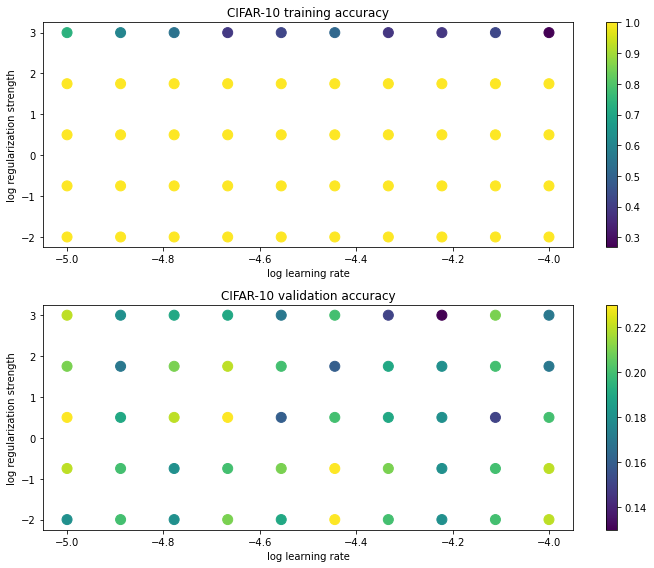

In [26]:
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')


colors = [results[x][1] for x in results] 
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
# 自动布局
plt.tight_layout()
plt.show()

In [27]:
#在测试数据集上评估最佳softmax分类器
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('测试集精度: %f' % test_accuracy)

测试集精度: 0.234500


我们观察到效果并不理想，这是因为我们训练的数据量实在是太小了。

数据量提升可以避免过拟合现象的发生，但同时也使得我们在选择超参数时耗时耗力。因此我们可以先使用较小的数据去粗略地选择超参数的取值范围，这样可以节约训练时间。但是在较小数据中表现最好的超参数，不一定在数据量较大时同样表现得更好，因此需要注意数据量的把控，但这是一个非常以来于经验的一个问题，需要从大量的实验中自己积累敬仰，进行不断地尝试。记住，千万不要怕错。

In [28]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=10000):
    cifar10_dir = 'datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir) 
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]    
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))    
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))]) 
    return X_train, y_train, X_val, y_val, X_test, y_test


X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print ('Train data shape: ', X_train.shape)
print ('Train labels shape: ', y_train.shape)
print ('Validation data shape: ', X_val.shape)
print ('Validation labels shape: ', y_val.shape)
print ('Test data shape: ', X_test.shape)
print ('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (10000, 3073)
Test labels shape:  (10000,)


In [30]:
from classifiers.chapter2.softmax  import Softmax
results = {}
best_val = -1
best_softmax = None
################################################################################
#                            任务:                                             #
#               使用全部训练数据训练一个最佳softmax                            #
################################################################################
learning_rates = [1.4e-7, 1.45e-7, 1.5e-7, 1.55e-7, 1.6e-7]  #学习率
regularization_strengths = [2.3e4, 2.6e4, 2.7e4, 2.8e4, 2.9e4]  #权重衰减因子
for l in learning_rates:
    for r in regularization_strengths:
        softmax = Softmax()
        loss_hist = softmax.train(X_train, y_train, learning_rate=l, 
                                  reg=r,num_iters=2000, verbose=True)
        y_train_pred = softmax.predict(X_train)
        train_accuracy= np.mean(y_train == y_train_pred)
        y_val_pred = softmax.predict(X_val)
        val_accuracy= np.mean(y_val == y_val_pred)
        results[(l,r)]=(train_accuracy,val_accuracy)
        if (best_val < val_accuracy):
            best_val = val_accuracy
            best_softmax = softmax
################################################################################
#                            结束编码                                          #
################################################################################

for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('最佳验证精度为: %f' % best_val)

迭代次数 0 / 2000: loss 362.275538
迭代次数 500 / 2000: loss 15.973378
迭代次数 1000 / 2000: loss 2.563832
迭代次数 1500 / 2000: loss 2.039525
迭代次数 0 / 2000: loss 402.579894
迭代次数 500 / 2000: loss 12.217043
迭代次数 1000 / 2000: loss 2.312635
迭代次数 1500 / 2000: loss 2.033261
迭代次数 0 / 2000: loss 420.798641
迭代次数 500 / 2000: loss 11.346001
迭代次数 1000 / 2000: loss 2.314607
迭代次数 1500 / 2000: loss 2.044269
迭代次数 0 / 2000: loss 440.503492
迭代次数 500 / 2000: loss 10.521333
迭代次数 1000 / 2000: loss 2.191913
迭代次数 1500 / 2000: loss 2.124927
迭代次数 0 / 2000: loss 453.308193
迭代次数 500 / 2000: loss 9.689195
迭代次数 1000 / 2000: loss 2.130514
迭代次数 1500 / 2000: loss 2.027209
迭代次数 0 / 2000: loss 362.176210
迭代次数 500 / 2000: loss 14.451922
迭代次数 1000 / 2000: loss 2.447913
迭代次数 1500 / 2000: loss 2.041807
迭代次数 0 / 2000: loss 402.706053
迭代次数 500 / 2000: loss 11.013674
迭代次数 1000 / 2000: loss 2.216208
迭代次数 1500 / 2000: loss 2.032448
迭代次数 0 / 2000: loss 421.450555
迭代次数 500 / 2000: loss 10.149416
迭代次数 1000 / 2000: loss 2.186461
迭代次数 1500 / 2000:

In [31]:
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('测试集精度: %f' % test_accuracy)

测试集精度: 0.354200


另一种直观检验模型好坏的方法是可视化模型参数，比如我们识别图片“马”，那模型的参数其实就是图片的“马模板”，也可以通过可视化参数来反推数据情况。比如我们的图片汇总如果存在大量“马头向左”与“马头向右”的图片，那训练出来的模型参数很可能就变成了“双头马”。同理，如果图片中汽车的颜色大多数都是红色，那训练出的模型就可能是一辆“红车模板”。

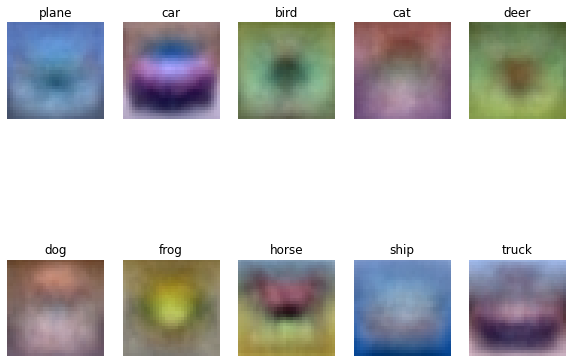

In [33]:
# 可视化学习到的参数
w = best_softmax.W[:-1,:] # 移除偏置项
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    #将权重缩放回0-255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])